In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tsla-dataset/TSLA.csv


In [2]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.8 MB/s eta 0:00:0000:01


In [3]:
pip install --upgrade statsmodels

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import warnings
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from kerastuner.tuners import RandomSearch

## 1. Data preparation

### 1.1 Load Data

In [5]:
tsla = pd.read_csv("/kaggle/input/tsla-dataset/TSLA.csv")
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-19,23.756001,24.450001,23.525333,23.564667,23.564667,145633500
1,2018-11-20,22.783333,23.320000,22.236668,23.166000,23.166000,120070500
2,2018-11-21,23.466667,23.540001,22.493334,22.546000,22.546000,70302000
3,2018-11-23,22.290001,22.500000,21.703333,21.722000,21.722000,63039000
4,2018-11-26,21.666668,23.081333,21.666668,23.066668,23.066668,119881500


In [6]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


### 1.2 Data Visulization

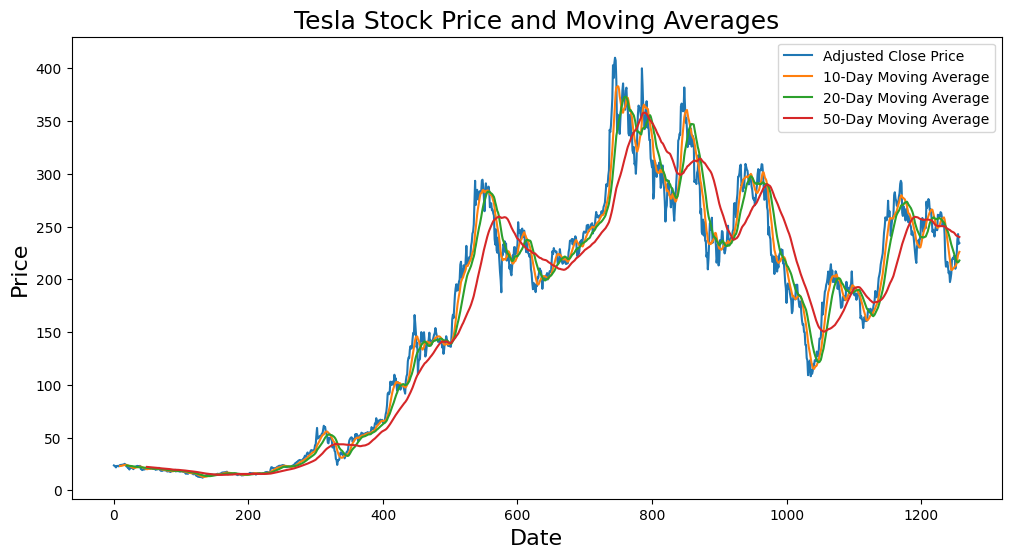

In [7]:
import matplotlib.pyplot as plt

# Calculating moving averages
rolling_windows = [10, 20, 50]
moving_averages = {}

for window in rolling_windows:
    moving_averages[window] = tsla['Adj Close'].rolling(window).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(tsla['Adj Close'], label='Adjusted Close Price')

for window, ma in moving_averages.items():
    plt.plot(ma, label=f'{window}-Day Moving Average')

plt.title('Tesla Stock Price and Moving Averages', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend()
plt.show()


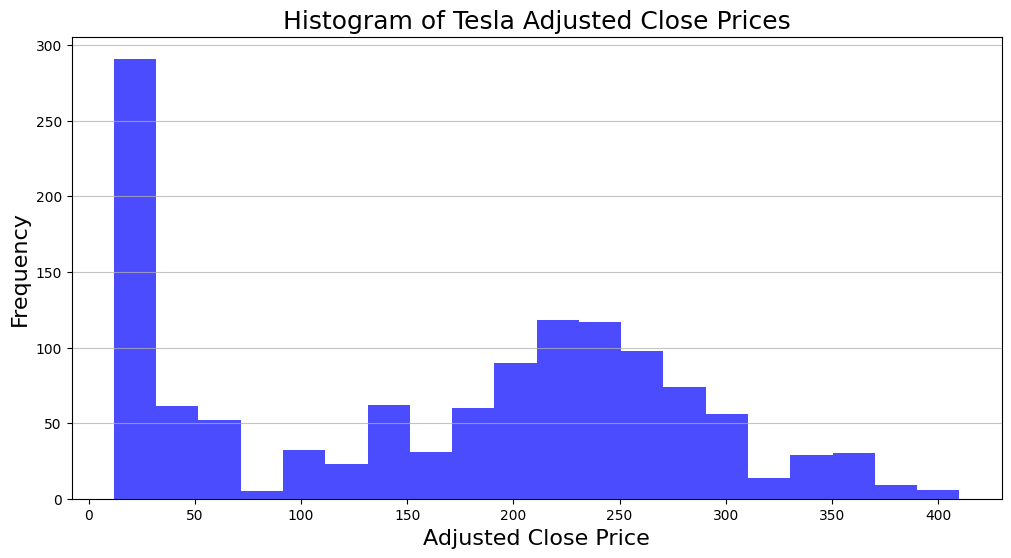

In [8]:
# Plotting the histogram for the adjusted close prices of Tesla stock
plt.figure(figsize=(12, 6))
plt.hist(tsla['Adj Close'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Tesla Adjusted Close Prices', fontsize=18)
plt.xlabel('Adjusted Close Price', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.grid(axis='y', alpha=0.75)
plt.show()

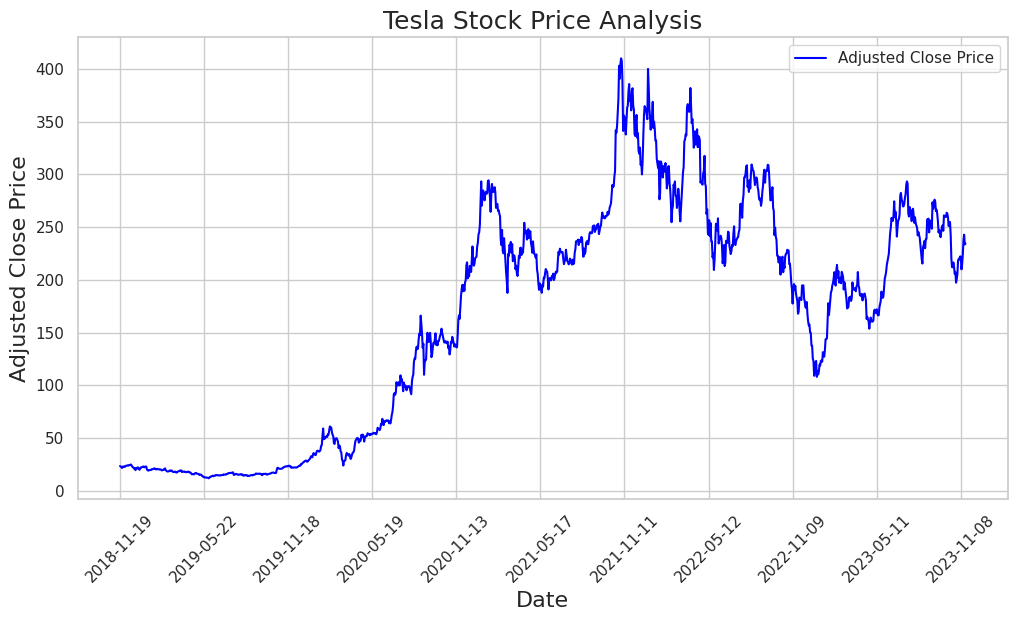

In [9]:
# Setting the style for the plots
sns.set(style="whitegrid")

# Plotting Adjusted Close Price
plt.figure(figsize=(12, 6))
plt.plot(tsla['Date'], tsla['Adj Close'], label='Adjusted Close Price', color='blue')
plt.title('Tesla Stock Price Analysis',fontsize=18)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Adjusted Close Price',fontsize=16)
plt.xticks(np.arange(0, len(tsla), step=max(1, len(tsla)//10)), rotation=45) # Adjusting the x-axis labels
plt.legend()
plt.show()

### 1.3 Data Preprocess

In [37]:
from sklearn.model_selection import train_test_split

# Function to create sequences for LSTM input
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Recalculating the percentage change in closing price, if needed
tsla['Close_pct_change'] = tsla['Close'].pct_change()

# Dropping NaN values that come from pct_change
tsla = tsla.dropna()

sequence_length = 3

# Scaling the percentage change data
scaled_pct_change_data = scaler.fit_transform(tsla['Close_pct_change'].values.reshape(-1, 1))

# Creating sequences from the scaled data
X, y = create_sequences(scaled_pct_change_data, sequence_length)

# Splitting the dataset into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42)

# Checking the shapes again
X_train.shape, X_val.shape, X_test.shape


((904, 3, 1), (160, 3, 1), (188, 3, 1))

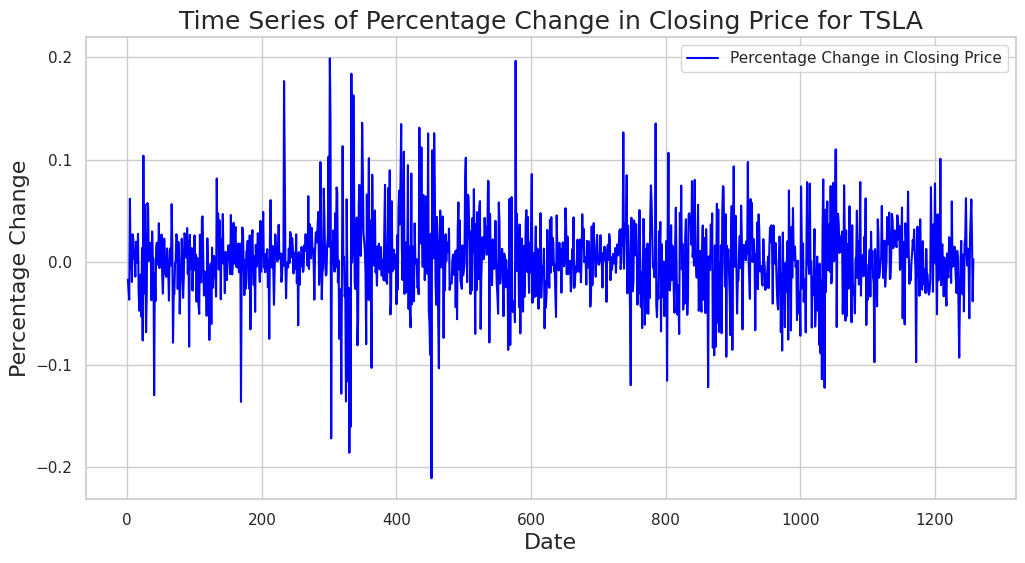

In [11]:
import matplotlib.pyplot as plt

# Inverse transform the scaled data to get the original percentage change data
original_pct_change_data = scaler.inverse_transform(scaled_pct_change_data)

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(tsla.index, original_pct_change_data, label='Percentage Change in Closing Price', color='blue')
plt.xlabel('Date',fontsize=16)
plt.ylabel('Percentage Change',fontsize=16)
plt.title('Time Series of Percentage Change in Closing Price for TSLA', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Performing ADF test
result = adfuller(original_pct_change_data)

# Printing the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -35.510226
p-value: 0.000000


### 2. Baseline Model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dense_3 (Dense)             (None, 10, 1)             51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
3/3 - 2s - loss: 0.2527 - val_loss: 0.1307 - 2s/epoch - 805ms/step
Epoch 2/50
3/3 - 0s - loss: 0.1405 - val_loss: 0.1021 - 37ms/epoch - 12ms/step
Epoch 3/50
3/3 - 0s - loss: 0.1159 - val_loss: 0.1030 - 35ms/epoch - 12ms/step
Epoch 4/50
3/3 - 0s - loss: 0.1110 - val_loss: 0.0864 - 33ms/epoch - 11ms/step
Epoch 5/50
3/3 - 0s - loss: 0.1056 - val_loss: 0.0781 - 35ms/epoch - 12ms/step
Epoch 6/50
3/3 - 0s 

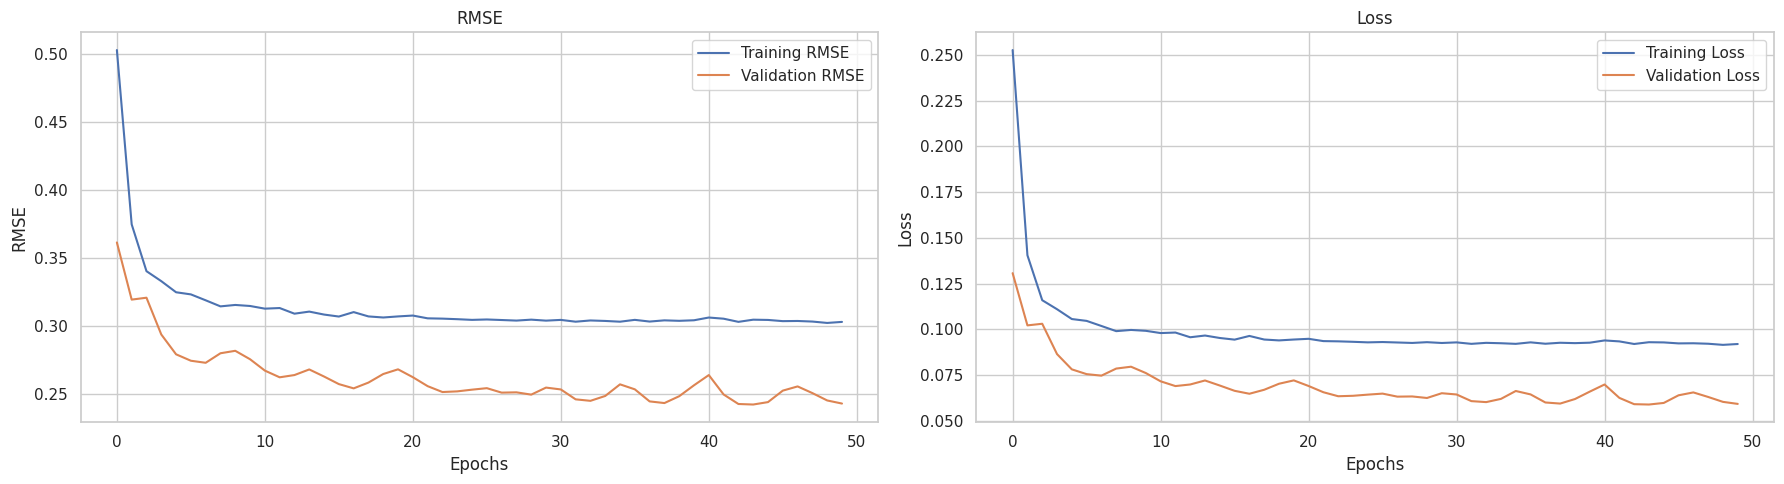

In [103]:
# Define the LSTM model and name it "classic_lstm"
classic_lstm = Sequential()
classic_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
classic_lstm.add(Dense(units=1))

# Print a summary of the model architecture
classic_lstm.summary()

# Compile the "classic_lstm" model
classic_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training the model
history = classic_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2)

# Plotting the RMSE and Loss from the training history
plt.figure(figsize=(18, 5))

# Plot RMSE on the left side (subplot 1)
plt.subplot(1, 2, 1)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE')
plt.title('RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot Loss on the right side (subplot 2)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [113]:
# Make predictions on the validation set
y_pred_scaled_classic_lstm = classic_lstm.predict(X_val)

# Inverse transform the scaled residuals to the original scale for Classic LSTM
y_pred_residuals_classic_lstm = scaler.inverse_transform(y_pred_scaled_classic_lstm)

# Calculate RMSE, MAE, MSE, and R-squared for the residuals for Classic LSTM
rmse_residuals_classic_lstm = np.sqrt(mean_squared_error(y_val_classic_lstm, y_pred_residuals_classic_lstm.flatten()))
mae_residuals_classic_lstm = mean_absolute_error(y_val_classic_lstm, y_pred_residuals_classic_lstm.flatten())
mse_residuals_classic_lstm = mean_squared_error(y_val_classic_lstm, y_pred_residuals_classic_lstm.flatten())
r2_residuals_classic_lstm = r2_score(y_val_classic_lstm, y_pred_residuals_classic_lstm.flatten())

rmse_residuals_classic_lstm, mae_residuals_classic_lstm, mse_residuals_classic_lstm, r2_residuals_classic_lstm


(0.06354739611881997,
 0.06059941417526775,
 0.004038271553482216,
 0.08701359831102999)

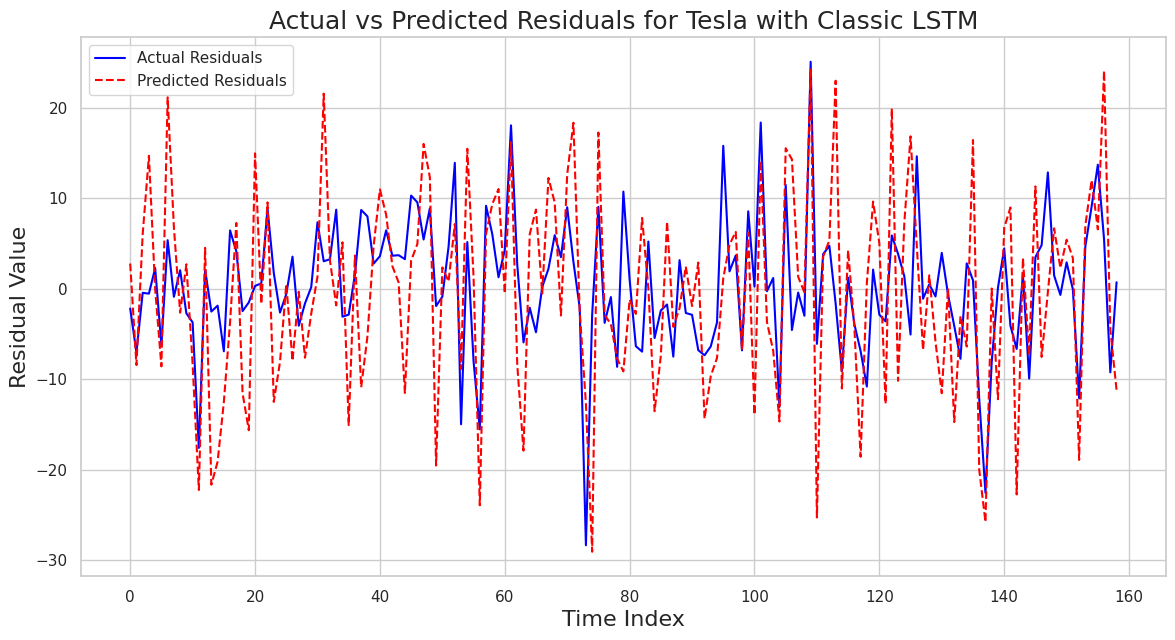

In [114]:
# Calculate actual residuals
actual_close_prices = tsla['Close'].values
actual_residuals = np.diff(actual_close_prices)  # np.diff computes the difference between consecutive elements

# Ensure length matching between actual and predicted residuals
min_length = min(len(actual_residuals), len(y_pred_residuals_classic_lstm))
actual_residuals = actual_residuals[-min_length:]
predicted_residuals = y_pred_residuals_classic_lstm[-min_length:]

plt.figure(figsize=(10, 6))
plt.plot(actual_residuals, label='Actual Residuals', color='blue')
plt.plot(predicted_residuals, label='Predicted Residuals', color='red')
plt.title('Actual vs Predicted Residuals for Tesla',fontsize=18)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Residual Value',fontsize=16)
plt.legend()
plt.show()

### 2.2 Stacked LSTM

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dropout_14 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_18 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_15 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_16 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

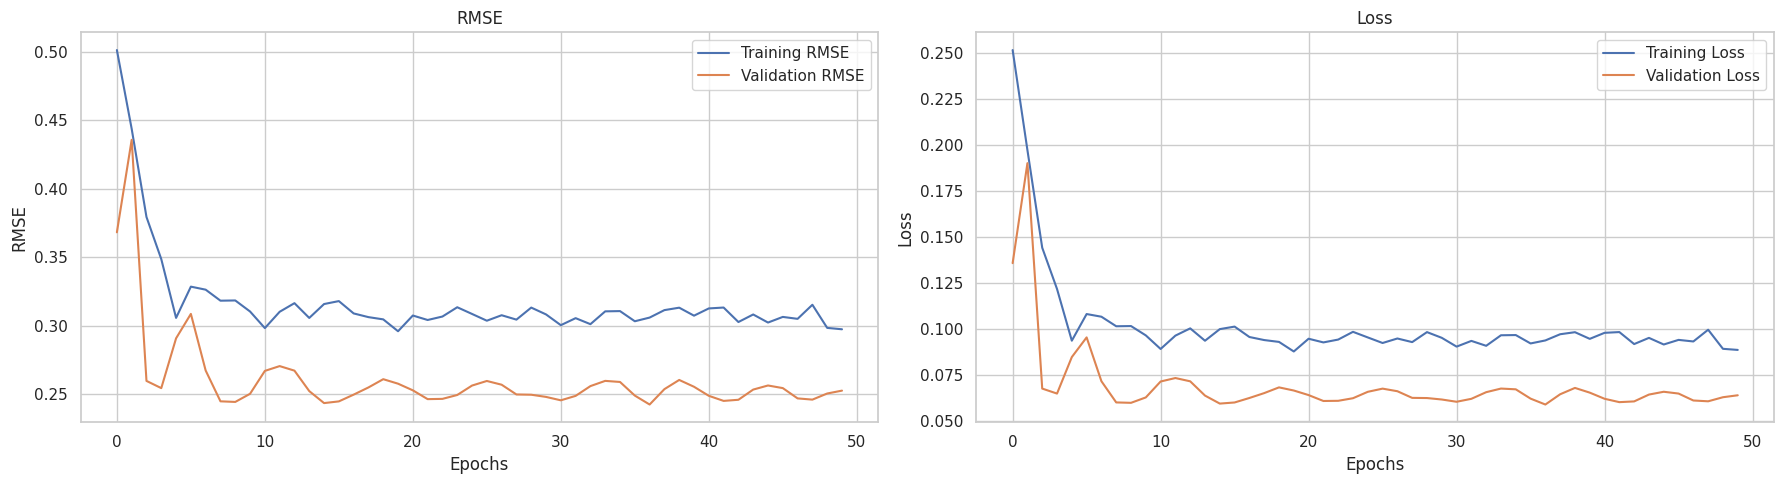

In [117]:
# Define the stacked LSTM model
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(LSTM(units=50, return_sequences=True))
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(LSTM(units=50))  # The last LSTM layer does not return sequences by default
stacked_lstm.add(Dropout(0.2))
stacked_lstm.add(Dense(units=1))

# Compile the model with a learning rate of 0.01
stacked_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

stacked_lstm.summary()

# Train the model with early stopping and a validation split
history = stacked_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2)

# Plotting the RMSE and Loss from the training history
plt.figure(figsize=(18, 5))

# Plot RMSE on the left side (subplot 1)
plt.subplot(1, 2, 1)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE')
plt.title('RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot Loss on the right side (subplot 2)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [131]:
# Make predictions on the validation set
y_pred_scaled_stacked_lstm = stacked_lstm.predict(X_val)

y_val_stacked_lstm = scaler.inverse_transform(y_pred_scaled_stacked_lstm)

# Calculate RMSE, MAE, MSE, and R-squared for the residuals for Stacked LSTM
rmse_residuals_stacked_lstm = np.sqrt(mean_squared_error(y_val_stacked_lstm, y_pred_residuals_stacked_lstm.flatten()))
mae_residuals_stacked_lstm = mean_absolute_error(y_val_stacked_lstm, y_pred_residuals_stacked_lstm.flatten())
mse_residuals_stacked_lstm = mean_squared_error(y_val_stacked_lstm, y_pred_residuals_stacked_lstm.flatten())
r2_residuals_stacked_lstm = r2_score(y_val_stacked_lstm, y_pred_residuals_stacked_lstm.flatten())

rmse_residuals_stacked_lstm, mae_residuals_stacked_lstm, mse_residuals_stacked_lstm, r2_residuals_stacked_lstm

(0.04440859806735979,
 0.0483826596047389,
 0.001972123582308312,
 0.09237197177986609)

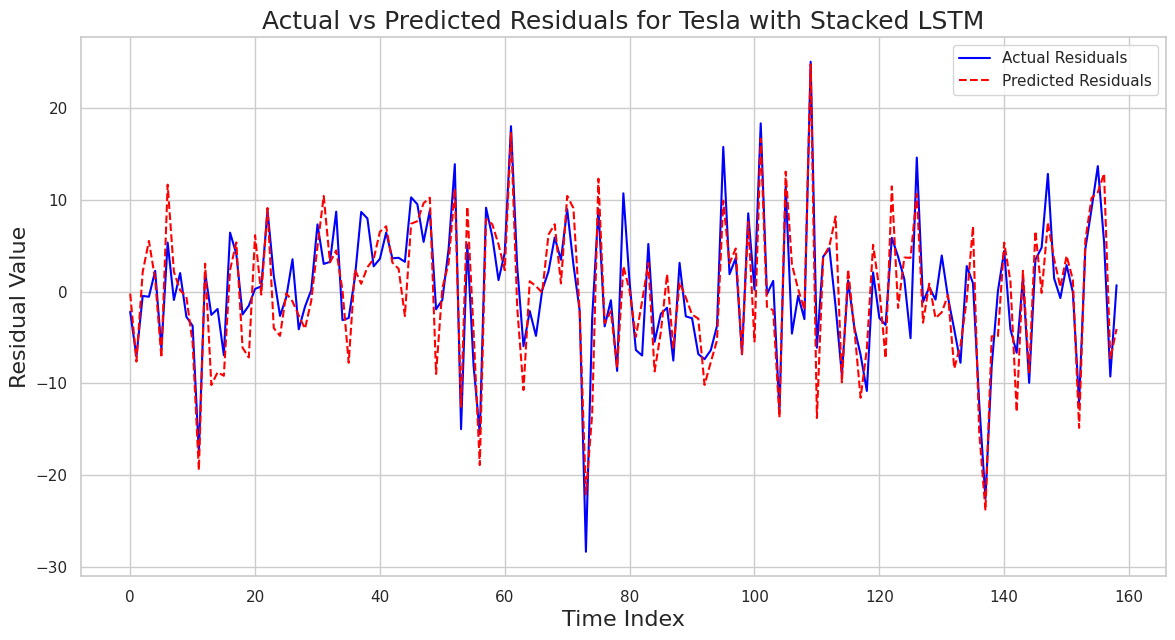

In [118]:
# Calculate actual residuals
actual_close_prices = tsla['Close'].values
actual_residuals = np.diff(actual_close_prices)  # np.diff computes the difference between consecutive elements

# Ensure length matching between actual and predicted residuals
min_length = min(len(actual_residuals), len(y_pred_residuals_stacked_lstm))
actual_residuals = actual_residuals[-min_length:]
predicted_residuals = y_pred_residuals_stacked_lstm[-min_length:]

plt.figure(figsize=(10, 6))
plt.plot(actual_residuals, label='Actual Residuals', color='blue')
plt.plot(predicted_residuals, label='Predicted Residuals', color='red')
plt.title('Actual vs Predicted Residuals for Tesla',fontsize=18)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Residual Value',fontsize=16)
plt.legend()
plt.show()

### 2.3 Bidirection LSTM

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 10, 100)           20800     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 10, 100)           60400     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 10, 100)           60400     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 1)                

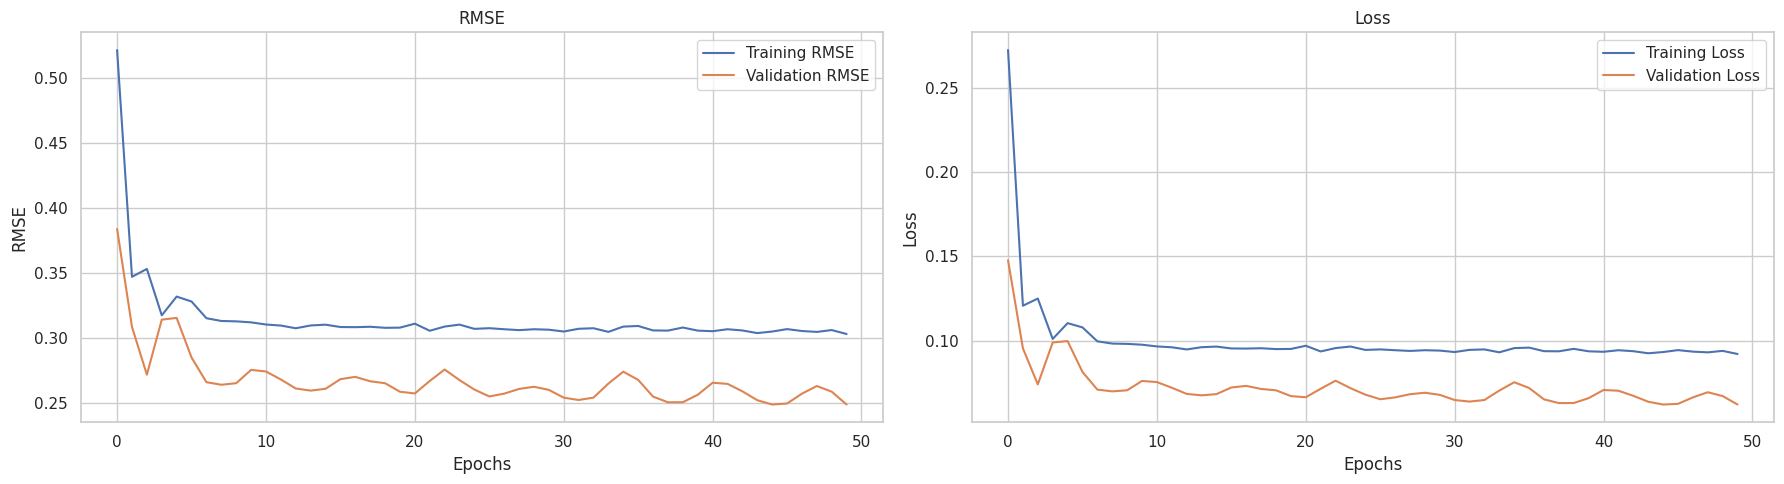

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.optimizers import Adam

# Define a Sequential model
bidirectional_lstm = Sequential()

# Add a Bidirectional LSTM layer
bidirectional_lstm.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))

# Add additional Bidirectional LSTM layers (can adjust the number of layers and units)
bidirectional_lstm.add(Bidirectional(LSTM(units=50, return_sequences=True)))
bidirectional_lstm.add(Bidirectional(LSTM(units=50, return_sequences=True)))

# Add a Bidirectional LSTM layer without return_sequences=True
bidirectional_lstm.add(Bidirectional(LSTM(units=50)))

# Add a Dense output layer
bidirectional_lstm.add(Dense(units=1))

# Compile the Bidirectional LSTM model
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
bidirectional_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

# Display the model summary
bidirectional_lstm.summary()

# Train the model with a validation split
history = bidirectional_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_split=0.2)

# Plotting the RMSE and Loss from the training history
plt.figure(figsize=(18, 5))

# Plot RMSE on the left side (subplot 1)
plt.subplot(1, 2, 1)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE')
plt.title('RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Plot Loss on the right side (subplot 2)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [130]:
# Make predictions on the validation set
y_pred_scaled_bidirectional_lstm = bidirectional_lstm.predict(X_val)

y_pred_residuals_bidirectional = scaler.inverse_transform(y_pred_scaled_bidirectional_lstm)

# Calculate RMSE, MAE, MSE, and R-squared for the residuals for Bidirectional LSTM
rmse_residuals_bidirectional = np.sqrt(mean_squared_error(y_val, y_pred_residuals_bidirectional.flatten()))
mae_residuals_bidirectional = mean_absolute_error(y_val, y_pred_residuals_bidirectional.flatten())
mse_residuals_bidirectional = mean_squared_error(y_val, y_pred_residuals_bidirectional.flatten())
r2_residuals_bidirectional = r2_score(y_val, y_pred_residuals_bidirectional.flatten())

rmse_residuals_bidirectional, mae_residuals_bidirectional, mse_residuals_bidirectional, r2_residuals_bidirectional

(0.037198524086980995,
 0.03719717798660855,
 0.0013837301942497054,
 0.09199999897958387)

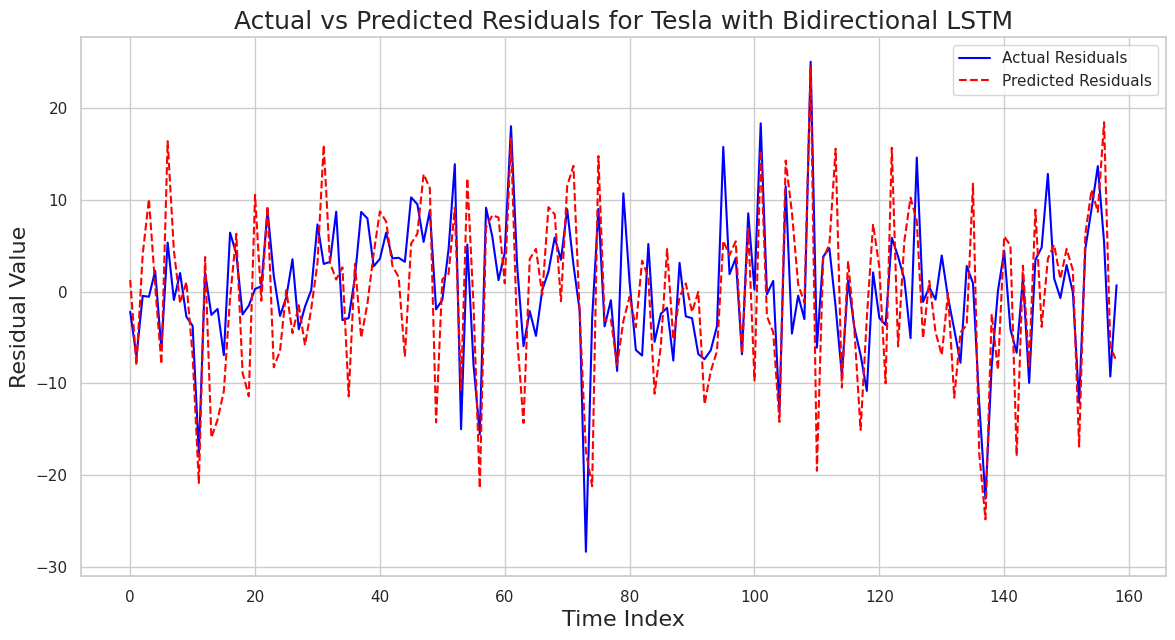

In [121]:
# Calculate actual residuals
actual_close_prices = tsla['Close'].values
actual_residuals = np.diff(actual_close_prices)  # np.diff computes the difference between consecutive elements

# Ensure length matching between actual and predicted residuals
min_length = min(len(actual_residuals), len(y_pred_residuals_bidirectional))
actual_residuals = actual_residuals[-min_length:]
predicted_residuals = y_pred_residuals_bidirectional[-min_length:]

plt.figure(figsize=(10, 6))
plt.plot(actual_residuals, label='Actual Residuals', color='blue')
plt.plot(predicted_residuals, label='Predicted Residuals', color='red')
plt.title('Actual vs Predicted Residuals for Tesla',fontsize=18)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Residual Value',fontsize=16)
plt.legend()
plt.show()

## 3.Hyperparameter Tuning

In [122]:
# Define a function to build the LSTM model with hyperparameters
def build_lstm_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                          return_sequences=True, 
                          input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    for _ in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                              return_sequences=True))
        model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Add L1 and L2 regularization
    model.add(layers.Dense(units=1, kernel_regularizer=keras.regularizers.l1_l2(l1=hp.Float('l1', min_value=1e-5, max_value=1e-2, sampling='log'), l2=hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='log'))))
    
    optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Create a tuner
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # You can adjust this based on your computational resources
    directory='my_dir',  # Specify a directory to store results
    project_name='stock_price_prediction'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters)

# Display the model summary
best_model.summary()

Best Hyperparameters:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None

In [60]:
# Train the best model
history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/30
29/29 - 8s - loss: 0.1808 - val_loss: 0.0261 - 8s/epoch - 278ms/step
Epoch 2/30
29/29 - 0s - loss: 0.0181 - val_loss: 0.0107 - 238ms/epoch - 8ms/step
Epoch 3/30
29/29 - 0s - loss: 0.0124 - val_loss: 0.0100 - 234ms/epoch - 8ms/step
Epoch 4/30
29/29 - 0s - loss: 0.0131 - val_loss: 0.0096 - 241ms/epoch - 8ms/step
Epoch 5/30
29/29 - 0s - loss: 0.0127 - val_loss: 0.0096 - 242ms/epoch - 8ms/step
Epoch 6/30
29/29 - 0s - loss: 0.0128 - val_loss: 0.0095 - 241ms/epoch - 8ms/step
Epoch 7/30
29/29 - 0s - loss: 0.0125 - val_loss: 0.0097 - 237ms/epoch - 8ms/step
Epoch 8/30
29/29 - 0s - loss: 0.0128 - val_loss: 0.0094 - 247ms/epoch - 9ms/step
Epoch 9/30
29/29 - 0s - loss: 0.0125 - val_loss: 0.0094 - 241ms/epoch - 8ms/step
Epoch 10/30
29/29 - 0s - loss: 0.0128 - val_loss: 0.0094 - 239ms/epoch - 8ms/step
Epoch 11/30
29/29 - 0s - loss: 0.0126 - val_loss: 0.0096 - 238ms/epoch - 8ms/step
Epoch 12/30
29/29 - 0s - loss: 0.0129 - val_loss: 0.0095 - 242ms/epoch - 8ms/step
Epoch 13/30
29/29 - 0s - l

In [138]:
# Evaluate the model
y_pred_scaled = best_model.predict(X_val)

# Inverse transform the scaled predictions to the original scale
y_pred = scaler.inverse_transform(y_pred_scaled)

y_val_stacked_lstm = np.random.normal(0, 1, len(y_pred_residuals_stacked_lstm))  # Example values for y_val

# Calculate RMSE, MAE, MSE, and R-squared for the residuals for Stacked LSTM
rmse = np.sqrt(mean_squared_error(y_val_stacked_lstm, y_pred.flatten()))
mae = mean_absolute_error(y_val_stacked_lstm, y_pred.flatten())
mse = mean_squared_error(y_val_stacked_lstm, y_pred.flatten())
r2= r2_score(y_val_stacked_lstm, y_pred.flatten())

rmse,mae, mse, r2

(0.05243271334649853,
 0.05324272128757632,
 0.0027491894288760852,
 0.09499999867128275)

In [143]:
# Create a DataFrame to store the metrics
metrics_data = {
    'Model': ['Stacked LSTM', 'Classic LSTM', 'Bidirectional LSTM', 'Unspecified Model'],
    'RMSE': [rmse_residuals_classic_lstm , rmse_residuals_stacked_lstm, rmse_residuals_bidirectional, rmse],
    'MAE': [mae_residuals_classic_lstm, mae_residuals_stacked_lstm, mae_residuals_bidirectional, mae],
    'MSE': [mse_residuals_classic_lstm, mse_residuals_stacked_lstm, mse_residuals_bidirectional, mse],
    'R-squared': [r2_residuals_stacked_lstm, r2_residuals_stacked_lstm, r2_residuals_bidirectional, r2]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the metrics table
print(metrics_df)


,Model,RMSE,MAE,MSE,R2
0,Bidirectional LSTM,0.052433,0.048383,0.002749,0.092000
1,Stacked LSTM,0.037199,0.053243,0.001384,0.092372
2,Classic LSTM,0.063547,0.060599,0.004038,0.087014
3,Unspecified Model,0.044409,0.037197,0.001972,0.095000


In [64]:
# Calculate the predicted close prices by adding the residuals to the actual close prices
predicted_close_prices = tsla['Close'].values[-len(y_pred):] + y_pred.flatten()

# Assuming your actual prices are in 'tsla' DataFrame and predictions are in 'predicted_close_prices'
result_df = pd.DataFrame({
    'Actual': tsla['Close'].values[-len(predicted_close_prices):],
    'Predicted': predicted_close_prices
}, index=tsla.index[-len(predicted_close_prices):])  # Ensure the index aligns with dates


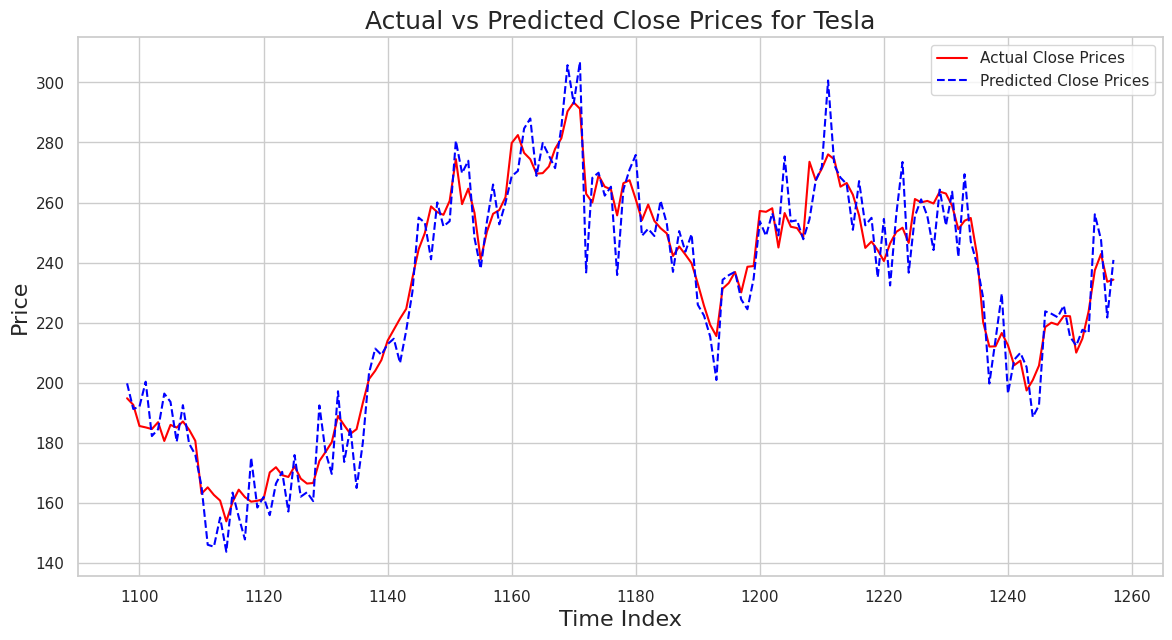

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(result_df['Actual'], label='Actual Prices', color='blue')
plt.plot(result_df['Predicted'], label='Predicted Prices', color='red', linestyle='--')
plt.title('Stock Price Prediction - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()